In [1]:
import numpy as np
from lib import view, traj_view
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
import json as json 
from ipywidgets import interact, fixed

![title](ML2.png)

# Récuparation de la base de données

Nous allons maintenant essayer d'apprendre automatiquement l'élasticité des matériaux crystallins. Nous avons une base de données qui contient 1181 matériaux crystallin et leur module d'élasticité $K$, calculé grace à une méthode de simulation qui s'appelle "théorie de la fonctionnelle de la densité". Pour les plus curieux, la génération de ces données est décrite ici: https://www.nature.com/articles/sdata20159. Les données en elle-même peuvent être récupérées ici: http://dx.doi.org/10.5061/dryad.h505v, mais nous en avons déjà mis une copie dans votre dossier de travail.

Nous avons vu que pour décrire des matériaux crystallins, il nous suffit de connaitre la cellule unitaire (avec les éléments et leur positions à l'intérieur) et trois vecteurs indiquant comment celle-ci se répéte. 

C'est exactement les informations que l'on récupère dans la base de données. La fonction "parser" ci-dessous collecte les données qui nous intéressent à partir d'un fichier json. Elle retourne 2 vecteurs:

- Le vecteur $mats$, dont chaque élément représente un matériau. Chaque matériau est représenté par un dictionnaire qui contient: le nombre atomique des élements de la cellule unitaire ("species"), leur positions ("positions"), et les vecteurs du crystal ("cell"), indiquant comment on doit répéter la cellule unitaire pour former le crystal.
- le vecteur $Ks$, qui contient les modules d'élasticité.

In [2]:
# À regarder
from elements import ELEMENTS
def parser(filename):
    #La fonction "json.load" permet d'importer le fichier dans une variable de type liste de dictionnaire.
    d = json.load(open(filename))
    mats=[]
    Ks=[]
    #on parcourt ensuite cette liste de dictionnaire et on récupère ce qu'il nous faut.
    for m in d:
        pos=m['poscar']
        lines=pos.splitlines()
        a=np.array([float(x) for x in lines[2].split()])
        b=np.array([float(x) for x in  lines[3].split()])
        c=np.array([float(x) for x in lines[4].split()])
        #if c[2]< 0: c=-c
        species=lines[5].split()
        spe_count=[int(x) for x in lines[6].split()]
        i=8
        p=[]
        mat={'species':[], 'positions':[],'cell':[a,b,c]}
        for j in range(sum(spe_count)):
            mat['positions'].append(sum([float(x)*np.array(mat['cell'][k]) 
                        for k,x in enumerate(lines[i+j].split()[:3])]))
            mat['species'].append(ELEMENTS[lines[i+j].split()[3]].number)
        mats.append(mat)
        #
        Ks.append(m["K_VRH"])
    return mats, np.array(Ks)
#
mats, Ks = parser('ec.json')

Explorer la base de donnée:

- Vérifier le nombre de matériaux dans la base de donnée, et le nombre de modules d'élasticité obtenus
- Imprimer un élément quelconque du vecteur $mats$, pour voir ce qu'il contient (le dictionnaire décrivant un matériau).
- Vous pouvez visualiser la cellule unitaire d'un matériau en appellant la fonction:
```python
view(mat)
```
où mat est un élement du vecteur $mats$. Vous pouvez aussi visualiser quelque répétitions de la cellule (par exemple 3 dans chaque direction) en appellant:
```python
view(mat, [3,3,3])
```

In [3]:
# À faire
print(len(mats), len(Ks))
i=123
mat = mats[i]
print(mats[i])
print(Ks[i])
view(mat, [3,3,3])

1181 1181
{'species': [3, 3, 3, 3, 9, 9, 9, 9], 'positions': [array([ 0.,  0.,  0.]), array([ 0.      ,  2.040743,  2.040743]), array([ 2.040743,  0.      ,  2.040743]), array([ 2.040743,  2.040743,  0.      ]), array([ 0.      ,  2.040743,  0.      ]), array([ 0.      ,  0.      ,  2.040743]), array([ 2.040743,  2.040743,  2.040743]), array([ 2.040743,  0.      ,  0.      ])], 'cell': [array([ 4.081486,  0.      ,  0.      ]), array([ 0.      ,  4.081486,  0.      ]), array([ 0.      ,  0.      ,  4.081486])]}
69.88112627


A Jupyter Widget

# Descripteurs

Nous allons maintenant construire des descripteurs pour nos matériaux. Chaque dimension du descripteur est un nombre, que l'on fabrique à partir des informations contenues dans $mats$. 

On commence simplement avec le volume par atome. C'est-à-dire le volume de la cellule unitaire divisé par le nombre d'atomes. Cela donne une mesure de la densité du matériaux (petit volume par atome => haute densité) 

Écrire une fonction NombreAtomes qui retourne le nombre d'atome dans la cellule primitive d'un matériau $mat$. Construire ensuite le vecteur Nat qui contient ce nombre pour chaque matériau.

In [4]:
# À faire
def NombreAtomes(mat):
    return len(mat['species'])

Nat = np.zeros(len(mats))
for i, mat in enumerate(mats):
    Nat[i] = NombreAtomes(mat) 
# oneliner: Nat=np.array([NombreAtomes(mat) for mat in mats])

Écrire une fonction Volume qui retourne le volume de la cellule primitive d'un matériau $mat$. Les matériaux de cette base de donnée sont tels que le volume est égal au produit des normes des trois vecteurs de répétition de la cellule unitaire $V=|a|\times|b|\times|c|$. 
Construire ensuite le vecteur $Volumes$ qui contient le volume de chaque matériaux.

Enfin, diviser $Volumes$ par $Nat$ pour créer le vecteur $VolumesParAtomes$

In [5]:
# À faire
def Volume(mat):
    a = mat["cell"][0][0]
    b = mat["cell"][1][1]
    c = mat["cell"][2][2]
    volume = np.abs(a*b*c) 
    return volume

Volumes = np.zeros(len(mats))
for i, mat in enumerate(mats):
    Volumes[i] = Volume(mat)
# oneliner Volumes = np.array([Volume(mat) for mat in mats])

VolumeParAtome=Volumes/Nat

Le volume par atome sera notre descripteur principal. Il est important de s'assurer que l'on va pouvoir effectuer une régression linéaire correcte avec ce descripteur. Pour cela on va devoir manipuler la variable à prédire, de sorte qu'elle dépendent approximativement linéairement du descripteur.

Regarder comment le module d'élasticité varie avec notre descripteur:
la figure intéractive suivante applique des transformations $y \to \hat{y}$ au module d'élasticité. Essayer les differentes transformations et choisir celle pour laquelle la relation entre le descripteur $x$ et le module d'élasticité transformé $\hat{y}$ ressemble le plus à une relation linéaire.

In [1]:
# À regarder puis jouer avec
x=VolumeParAtome
y=Ks
def plot(x,y,func):
    if func=='identité':
        toplot=y
    elif func=='inverse':
        toplot=1./y
    elif func=='log':
        toplot=np.log(y)
    elif func=='exp':
        toplot=np.exp(y)
    elif func=='1/sqrt':
        toplot=np.sqrt(1./y)
    elif func=='sqrt':
        toplot=np.sqrt(y)
    elif func=='carre':
        toplot=y**2
    else:
        print("fonction par reconnue")
        toplot=y
    fig=plt.figure()
    ax=plt.subplot(111,xlabel='x', ylabel='y')
    ax.scatter(x, toplot)
    plt.show()
#
interact(plot,x=fixed(x), y=fixed(y), func=['identité','exp','sqrt','carre','log','inverse', '1/sqrt'])

NameError: name 'VolumeParAtome' is not defined

Pour mieux differencier les matériaux, il faut injecter plus d'informations dans note apprentissage automatique.
Nous allons essayer d'obtenir des informations d'ordre chimique, sur le type d'éléments présents.

Indirectement, cela contiendra aussi un peu d'information sur le type de liaisons chimiques présentes dans le matériaux. On peut comprendre intuitivement que les liaisons sont trés influentes. Chaque liaison est comme un ressort liant les constituents du matériau. Le module d'élasticité du matériau dépend fortemement de la rigidité de chaqun de ces ressort. Les détails de cette dépendence ne sont pas évidents (cela va dépendre aussi de l'orentation relative des ressorts, etc...), mais l'avantage de l'apprentissage automatique est que nous allons laisser la machine "apprendre" ces détails pour nous.


Au long de l'exercise, nous allons construire des descripteurs de dimension de plus en plus grande, contenant de plus en plus d'information. Commencer par implémenter le descripteur suivant:

- un vecteur à 2 dimensions contenant, pour chaque matériau, la proportion de métaux et de non-métaux. Plus précisement, prendre le nombre de non-métaux et diviser par le nombre d'atomes. Dans le tableau ci-dessous, les non métaux correspondent au coin en haut à droite, contenant les éléments de couleur: bleu (He), vert (comme N), vert-bleu (comme C), et marron (comme B). Les autres sont des métaux. 

Continuer l'exercise et effectuer la régréssion en associant ce descripteur au volume par atome 

Une fois cela fait, revenir ici et implementer un nouveau descripteur:

- un descripteur à 7 dimensions contenant la proportion d'éléments chimiques dans chaque groupe indiqué par les couleurs du tableau des éléments ci-dessous. La proportion d'élément, c'est le nombre d'atomes appartenant à un certain groupe divisé par le nombre total d'atomes dans la cellule unitaire.

encore une fois, continuer l'exercise et effectuer la régréssion en associant ce nouveau descripteur au volume par atome.

Recommencer une dernière fois, si le temps le permet, avec un dernier descripteur:

- un descripteur à $N$ dimensions ($N$ étant le nombre d'éléments différents présent dans la base de donnée) contenant la proportion de chaque élément. Donc le nombre d'atome d'un certain élément diviser par le nombre total d'atomes dans le cellule unitaire.


![title](PT.png)

In [7]:
# À faire

# 1er descripteur:
non_metaux = [1,7,8,9,17,35,53,5,14,32,33,51,52,6,15,16,34]

des_nm=np.zeros((len(mats),2))
for j,m in enumerate(mats):
    nm=0
    for e in m['species']:
        if e in non_metaux:
            nm+=1.
    des_nm[j,0]= nm/Nat[j]
    des_nm[j,1]= (Nat[j]-nm)/Nat[j]
        

# 2eme descripteur :
groupes = { 
0 : [1,7,8,9,17,35,53], 
1 : [3,11,19,37,55],
2 : [4,12,20,38,56],
3 : [13,30,31,48,49,50,80,81,82,83],
4 : [5,14,32,33,51,52], 
5 : [6,15,16,34], 
6 : [21,22,23,24,25,26,27,28,29,39,40,41,42,43,44,45,46,47,72,73,74,75,76,77,78,79]}

des_groupe = np.zeros((len(mats),7))
for j,m in enumerate(mats):
    for e in m["species"] :
        for g,list_e in groupes.items() :
            if e in list_e:
                des_groupe[j,g]+=1./Nat[j]

# 3eme Descripteur:
# D'abord, on doit savoir quel éléments sont présents dans la base de donnée. 
# On crée une liste des éléments (unique) présent
BD_elements = []
for mat in mats:
    for e in mat["species"]:
        if e not in BD_elements:
            BD_elements.append(e)
# on les ordonne par nombre atomique croissant
BD_elements=sorted(BD_elements)
            
#le descripteur compte le nombre d'occurences de chaque élément dans 
# la liste d'atomes de la cellule unitaire. 
des_el = np.zeros((len(mats),len(BD_elements))) 
for j,m in enumerate(mats):
    for e in m["species"] :
        des_el[j,BD_elements.index(e)] += 1./Nat[j]

La ligne ci-dessous permet de définir rapidement le descripteur combinant VolumeParAtome et un autre descripteur multidimensionel. 

In [ ]:
X = np.column_stack((VolumeParAtome,des_el))

# Régression linéaire

On fourni les fonctions ci-dessous pour effectuer l'apprentissage. Regarder le code, et s'assurer que l'on comprend tout. Pour effectuer la régression linéaire en elle-mėme, on utilise la fonction minimize de la librairie scipy.optimize. C'est l'équivalent de l'algorithme que vous avez écrit dans l'intro, mais plus efficace et général. En particulier, il permet de gérer la présence d'un $b$ and $f(x)= ax+b$ et il n'est pas nécessaire de connaitre à priori l'interval dans lequel se trouve les pentes.

In [8]:
# À regarder
from scipy.optimize import minimize

# une fonction qui calcule la prédiction à partir des descripteurs et 
# des paramètre du modèle trouvé par régression.
def Prediction(a,X):
    pred = np.dot(X,a) # equivalent de y=a*x en plusieurs dimensions
    return pred
# Une fonction qui calcule le Cout associé à un vecteur de paramètres donné
def Cout(a,y_true,X):
    # valeur moyenne de la racine des differences au carrée
    return np.sqrt(((y_true-Prediction(a,X))**2).mean()) 

# Une fonction qui sépare les données en 2 ensembles, un pour apprendre, 
# un pour tester (en proportion "fac"), puis 
# effectue la régression et retourne:
# x_train, y_train: les données d'entrainement
# x_test,y_test: les données de test
# a_opt, y_pred: les paramètres trouvés et les prédictions du modèle
def Apprentissage(X,Y,fac):
    ######################  Préparation
    # trouver le nombre totale de données 
    ntot=len(Y)
    # en déduire le nombre de données d'entrainement avec "fac" 
    # (arrondir à l'entier en dessous)
    ntrain = int(fac*ntot)
    # Mélanger les indices pour faire un échantillonage aléatoire:
    indices = np.arange(ntot)
    np.random.shuffle(indices)
    # En déduire les indices des ensemble d'entrainement et de test:
    itest = indices[ntrain:]
    itrain = indices[:ntrain]
    # Définir les x_train, y_train, x_test, y_test:
    x_train = X[itrain]
    y_train = Y[itrain]
    x_test=X[itest]
    y_test=Y[itest]
    #
    #################################  Régression
    # Générer des paramètres initiaux aléatoirement:
    a0 = np.random.random(len(X[0]))
    # Minimiser avec l'optimiseur scipy:
    solution = minimize(lambda a: Cout(a,y_train,x_train),a0)
    a_opt = solution.x
    # Cela nous donne les paramètres du modèle... 
    # que l'on utilise pour trouver les prédictions:
    y_pred=Prediction(a_opt,x_test)
    #
    ############################# Imprime quelques résultats
    # paramètres:
    print('paramètres du modèle: ', a_opt)
    # Le Cout:
    print("Cout: %.2f"
          % Cout(a_opt,y_test, x_test))
    return x_train, y_train, x_test,y_test, a_opt, y_pred

Effectuer l'apprentissage et regarder les résultats!

paramètres du modèle:  [ 0.00207369  0.24693816  0.16320826  0.07155823  0.04388999  0.04826564
  0.02880855  0.0676561   0.04730371  0.21542361  0.10631676  0.06832068
  0.05496483  0.06505201  0.04694238  0.15624427  0.20425248  0.13630999
  0.06787997  0.04930055  0.0414036   0.04226865  0.05238998  0.0495185
  0.0438343   0.04446532  0.06306629  0.07905116  0.094335    0.08849402
  0.08209747  0.1061916   0.14606387  0.21748009  0.17683043  0.07475093
  0.04838126  0.03180246  0.02834037  0.02845336  0.0214543   0.02630819
  0.04023394  0.06620004  0.08916451  0.11645682  0.07522846  0.08038691
  0.18208654  0.17988394  0.34662491  0.18525097  0.04082057  0.02940229
  0.01877504  0.0151742   0.01221542  0.01571605  0.0240607   0.05009232
  0.1336919   0.12926894  0.09412464  0.22745416]
Cout: 0.02
pourcentage d'erreur moyen sur module d'élasticité:  18.5816342103 %


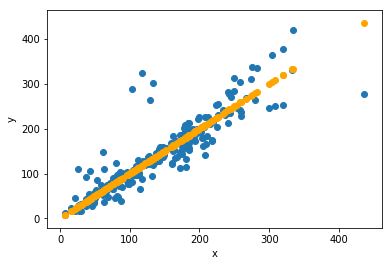

In [9]:
# À faire
#
# Définir la variable à prédire, en applicant 
# la meilleure transformation trouvée plus haut.
Y=1./np.sqrt(Ks)
#
# Apprentissage
x_train, y_train, x_test,y_test,a_opt, y_pred= Apprentissage(X,Y, 0.8)
#
# Récuperer le module d'élasticiteé 
# en appliquant la transformation inverse
Ypred=1./(y_pred)**2
Ytest=1./(y_test)**2

#Calculer le pourcentage d'erreur moyen sur les prédictions
err=np.mean(np.abs( Ypred - Ytest)/np.abs(Ytest)*100)
print("pourcentage d'erreur moyen sur module d'élasticité: ", np.mean(err),"%")
# plotter les résultat: élasticité prédit VS élasticité vraie!
fig=plt.figure()
ax=plt.subplot(111,xlabel='x', ylabel='y')
ax.scatter(Ytest,Ypred)
ax.scatter(Ytest,Ytest, c='orange')
plt.show()